In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
from SHDataset import SHDataset
import numpy as np
import matplotlib.pyplot as plt
from utils import *
from metrics import *

In [6]:
dataset = SHDataset(noise=True, dataset_dir='./dataset_250/')

In [20]:
G1,T1,G2,T2 = dataset.read_snapshots(0)

In [21]:
bbox = (52.355, 52.365, 4.860, 4.900)
G1,T1,G2,T2 = filter_bbox_snapshots(G1,T1,G2,T2,bbox)

### Visualizing Maps + Trajectories & Changes

#### Visualizing Maps + Trajectories

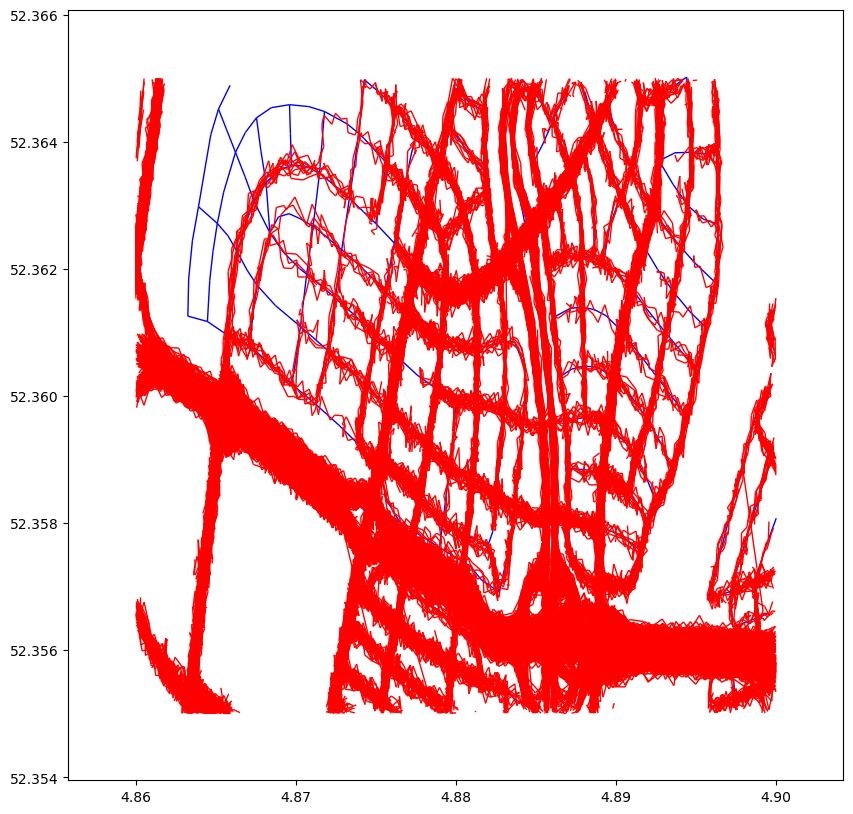

In [22]:
plot_graph(snapshot_to_nxgraph(G1,T2['T']), figsize=(10,10))

#### Visualizing Changes

In [7]:
G1_d, G12_d, G2_d, G21_d = compare_snapshots(G1,G2)

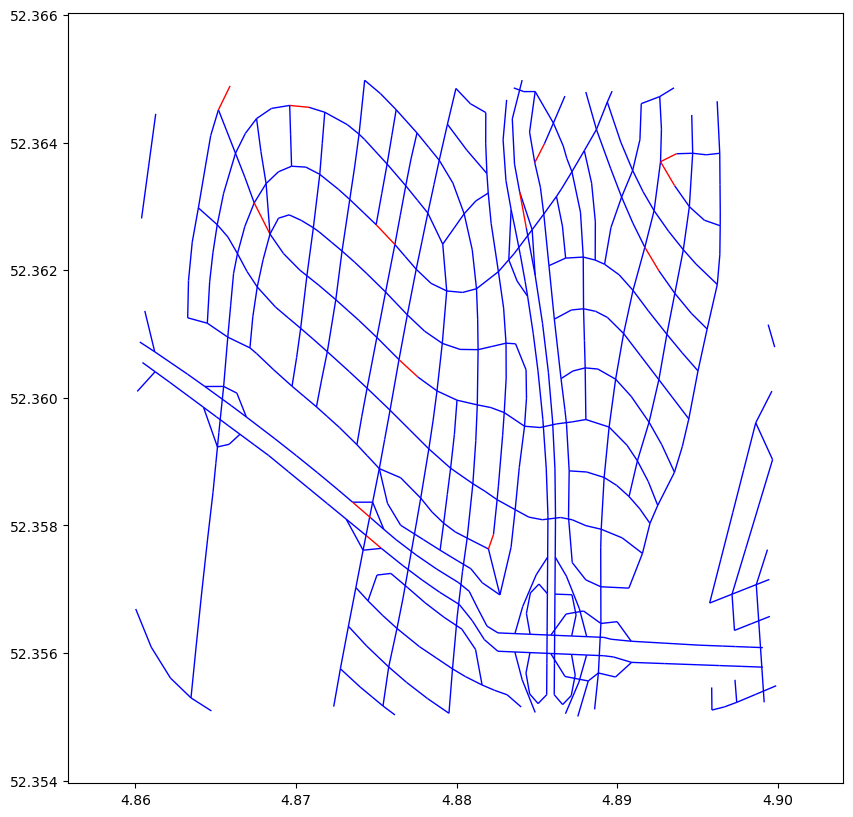

In [37]:
plot_graph(G12_d, figsize=(10,10))

### Change Detectors

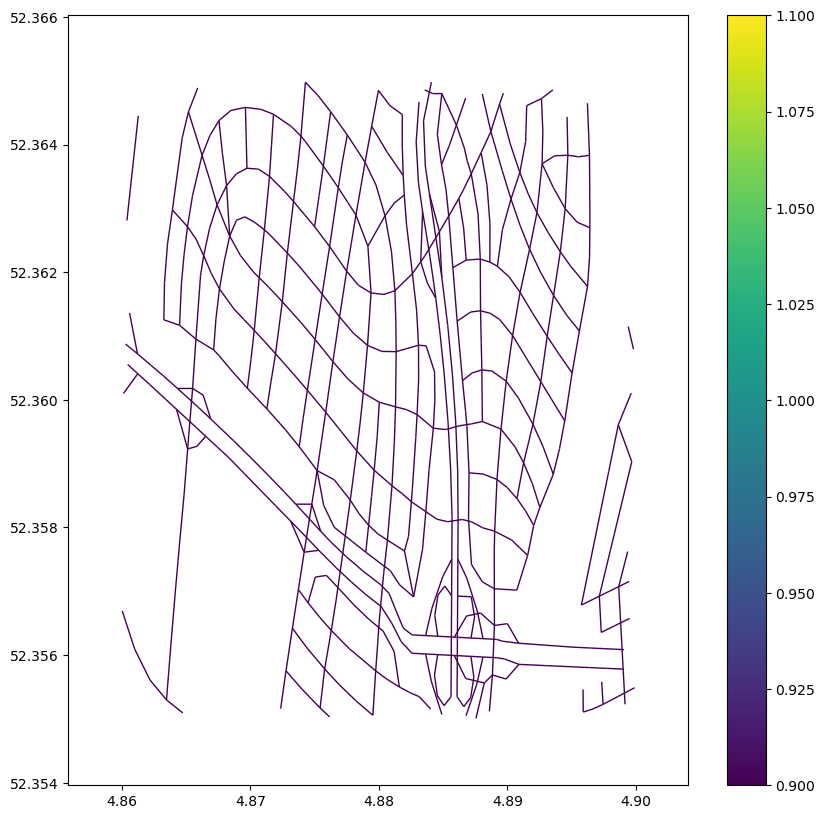

In [9]:
from models.always_true import AlwaysTrueDetector

alwaystrue_det = AlwaysTrueDetector(G1)
G2_pred_true = alwaystrue_det.forward(T2)
plot_graph(G2_pred_true, use_weights=True, figsize=(10,10))

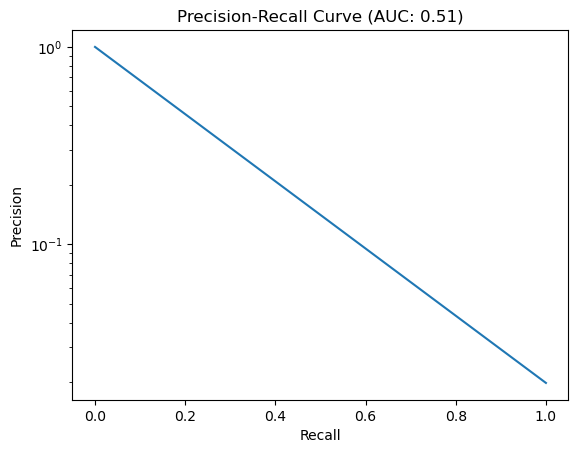

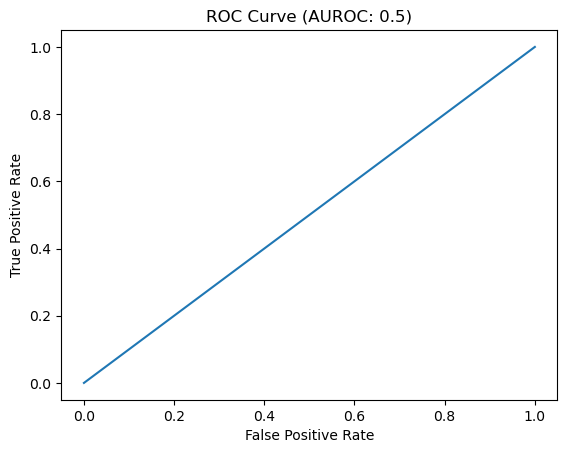

In [10]:
from metrics import *

scores_true = predicted_labels(G2_pred_true)
p_true, r_true, ts_true, pr_auc_true = PRCurve(groundtruth_labels(G1, G2), scores_true, norm=False)
tpr_true, fpr_true, auroc_true = ROCCurve(groundtruth_labels(G1, G2), scores_true)

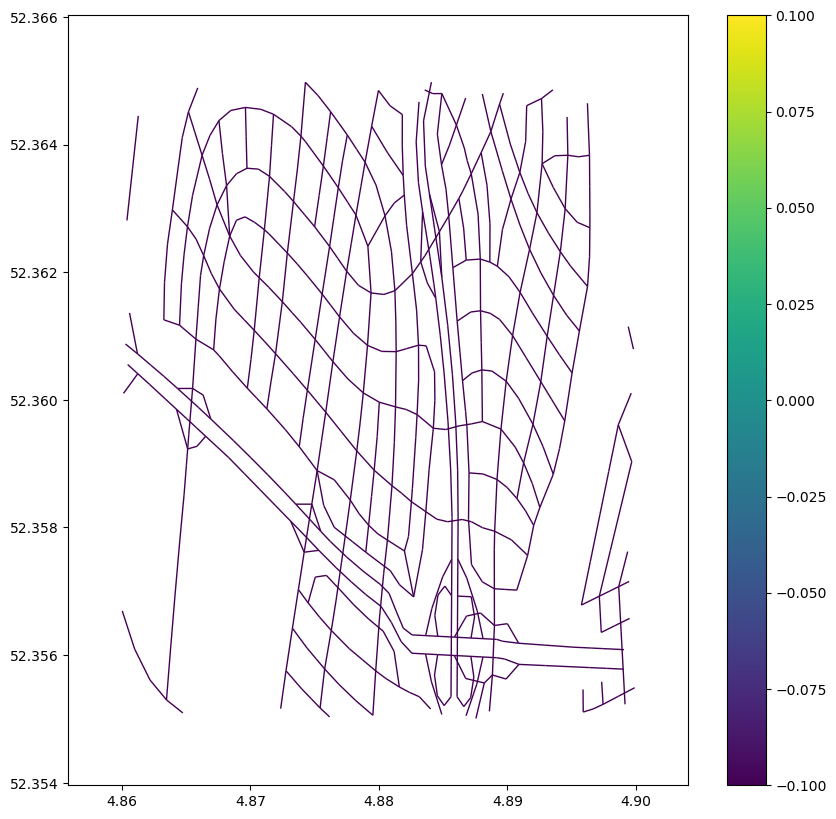

In [11]:
from models.always_false import AlwaysFalseDetector

alwaysfalse_det = AlwaysFalseDetector(G1)
G2_pred_false = alwaysfalse_det.forward(T2)
plot_graph(G2_pred_false, use_weights=True, figsize=(10,10))

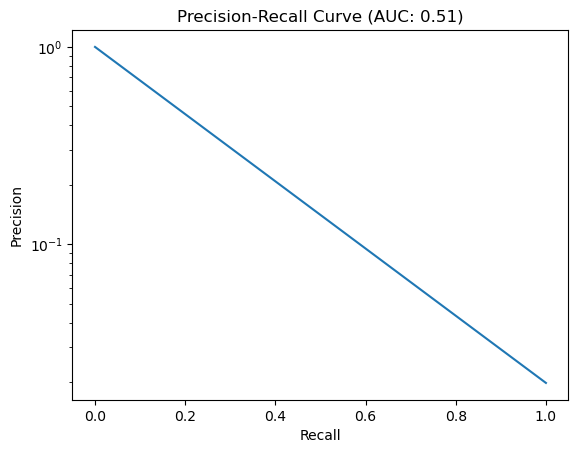

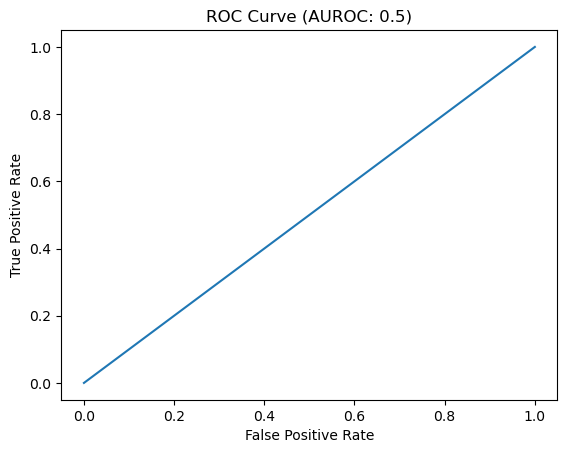

In [12]:
scores_false = predicted_labels(G2_pred_false)
p_false, r_false, ts_false, pr_auc_false = PRCurve(groundtruth_labels(G1, G2), scores_false)
tpr_false, fpr_false, auroc_false = ROCCurve(groundtruth_labels(G1, G2), scores_false)

#### Random Change Detector

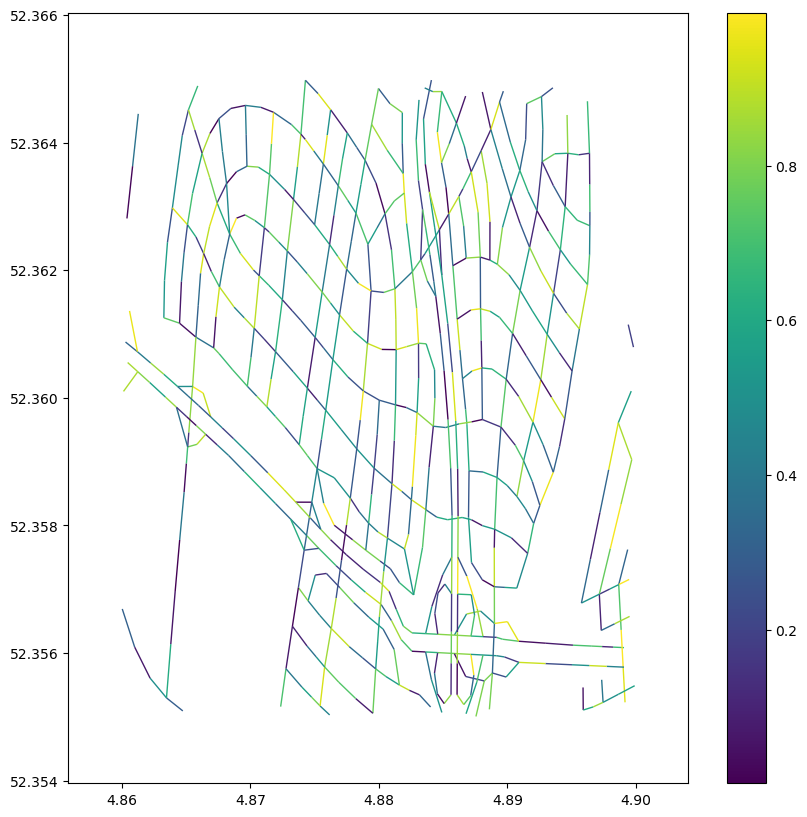

In [13]:
from models.random import RandomDetector

random_det = RandomDetector(G1)
G2_pred_rand = random_det.forward(T2)
plot_graph(G2_pred_rand, use_weights=True, figsize=(10,10))

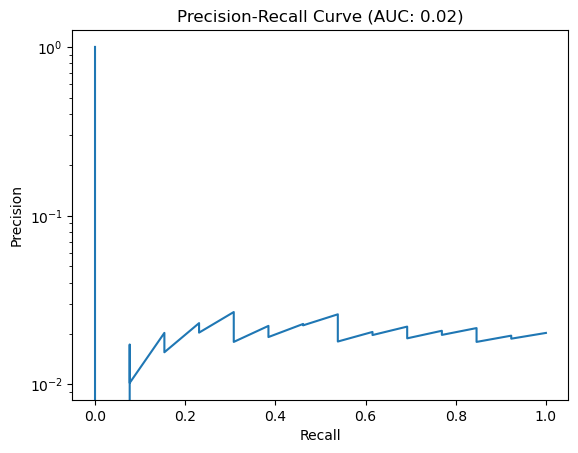

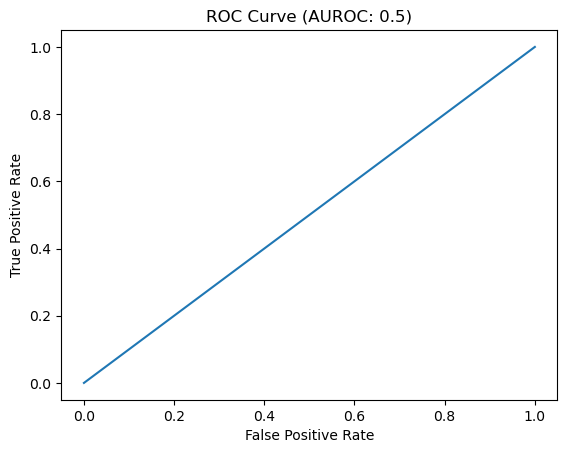

In [14]:
scores_rand = predicted_labels(G2_pred_rand)
p_rand, r_rand, ts_rand, pr_auc_rand = PRCurve(groundtruth_labels(G1, G2), scores_rand)
tpr_rand, fpr_rand, auroc_rand = ROCCurve(groundtruth_labels(G1, G2), scores_false)

In [15]:
# edges, edge_weights = zip(*nx.get_edge_attributes(G2_pred, 'weight').items())

# w = ((t := (edge_weights - np.min(edge_weights)))/t.max() +1e-7)
# #w[w==0] = np.nan
# #w = np.exp(w)
# #w = (t := w - w.min())/t.max()
# w = w.tolist()

# class cm_(plt.cm.viridis.__class__):
#     def __call__(self, v):
#         if v == 0:
#             return (1, 0, 0, 1)
#         return super().__call__(1 - v)

# cm = cm_(plt.cm.viridis.colors)

# node_lats = nx.get_node_attributes(G2_pred, 'lat')
# node_lons = nx.get_node_attributes(G2_pred, 'lon')
# node_pos = {node: (node_lons[node], node_lats[node]) for node in nodes}
# nx.draw_networkx_edges(G2_pred, node_pos, width=1.0, edge_color=w, edge_cmap=cm, ax=plt.subplots(figsize=(30,30))[1])

#### Rule-based Change Detector

In [16]:
from models.rulebased import RulebasedDetector

rule_det = RulebasedDetector(G1)
G2_pred_rb = rule_det.forward(T2['T'])

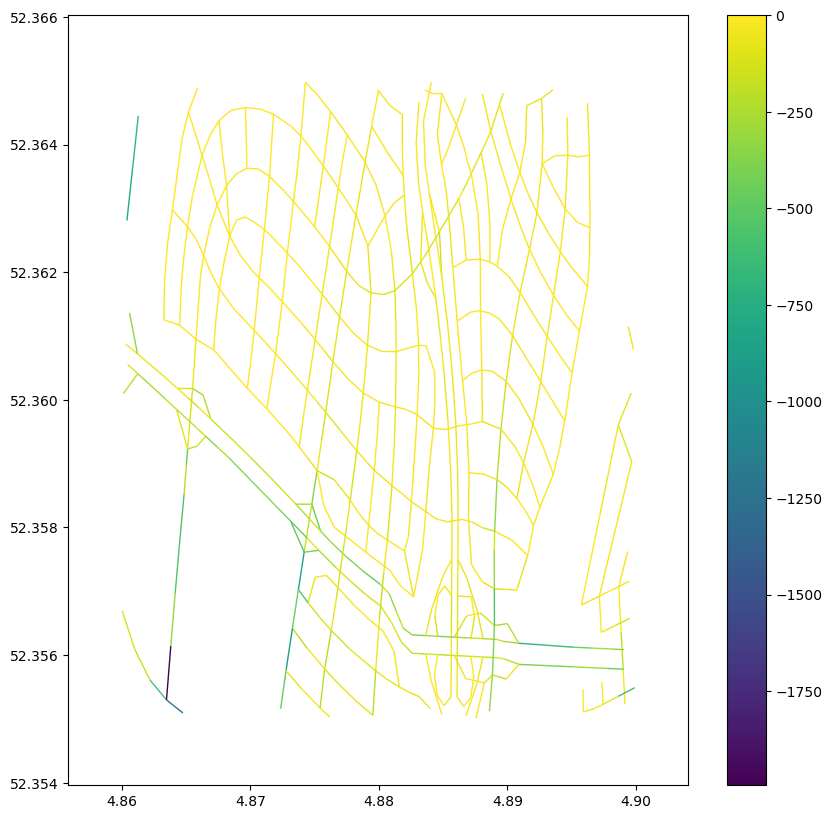

In [17]:
plot_graph(G2_pred_rb, use_weights=True, figsize=(10,10))

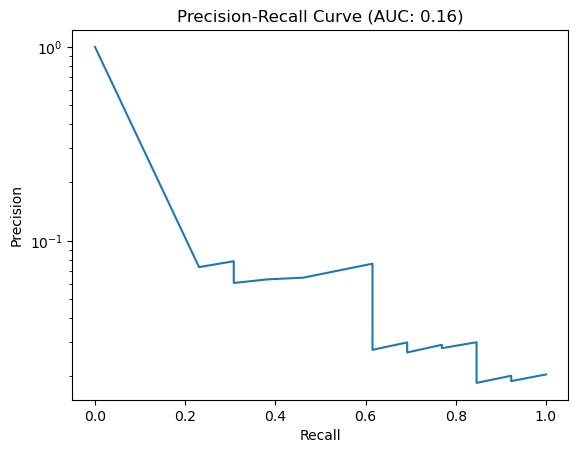

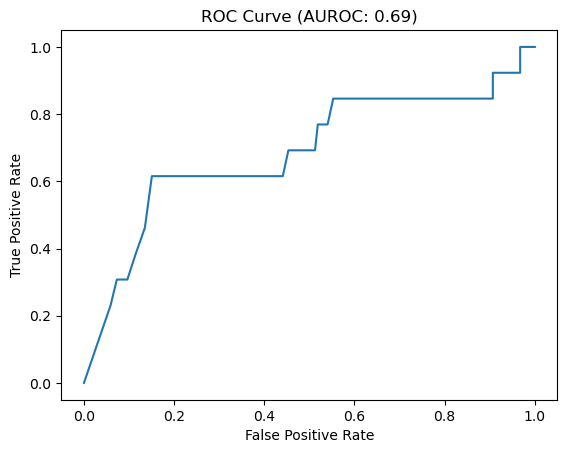

In [18]:
scores_rb = predicted_labels(G2_pred_rb)
p_rb, r_rb, ts_rb, pr_auc_rb = PRCurve(groundtruth_labels(G1, G2), scores_rb)
tpr_rb, fpr_rb, auroc_rb = ROCCurve(groundtruth_labels(G1, G2), scores_rb)

### HMM Based Change Detector

In [19]:
from models.hmm import HMMChangeDetector

hmm_det = HMMChangeDetector(G1, use_latlon=False)
G2_pred_hmm = hmm_det.forward(T2['T'])

Map matching trajectory: 1826/1827: : 1827it [19:05,  1.59it/s]

No matches for 407/1827 trajectories


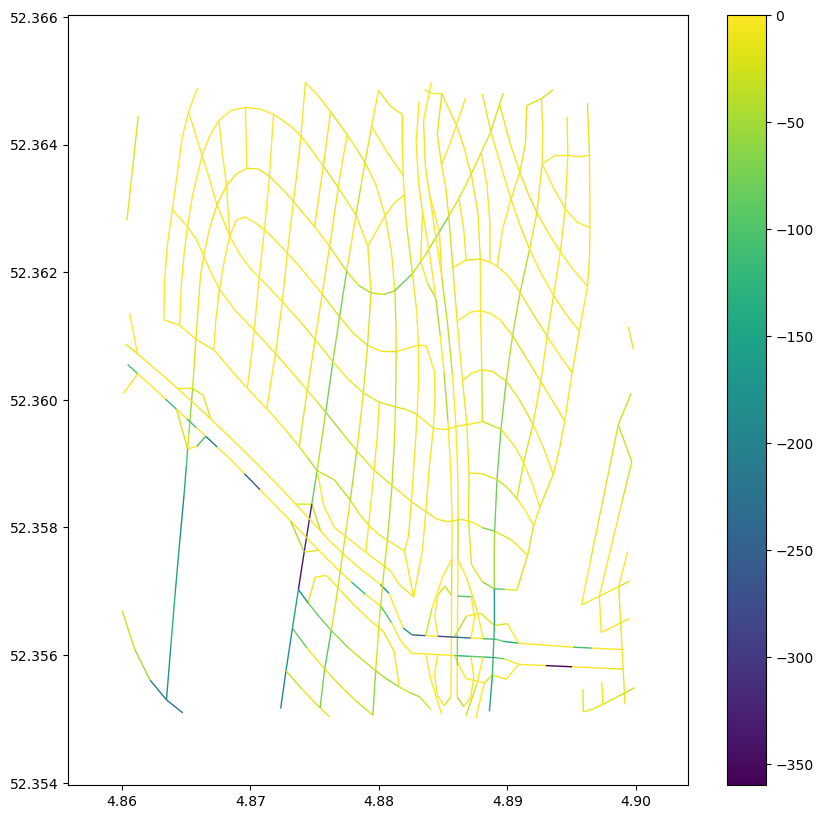

In [20]:
plot_graph(G2_pred_hmm, use_weights=True, figsize=(10,10))

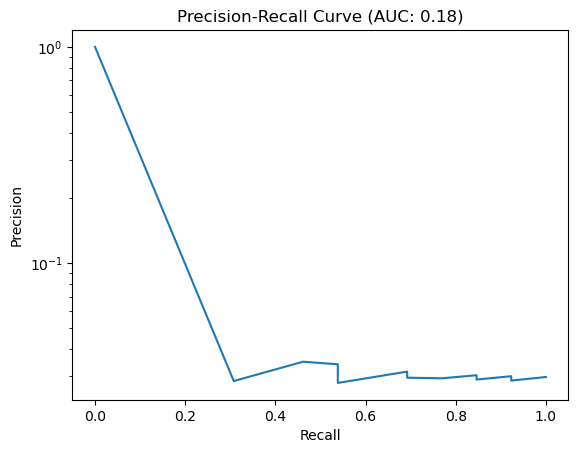

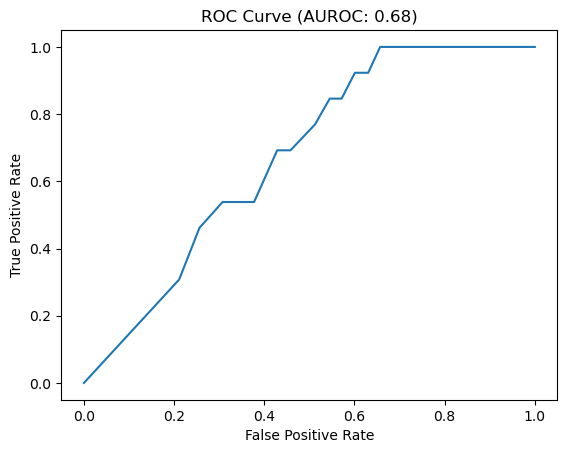

In [21]:
scores_hmm = predicted_labels(G2_pred_hmm)
p_hmm, r_hmm, ts_hmm, pr_auc_hmm = PRCurve(groundtruth_labels(G1, G2), scores_hmm)
tpr_hmm, fpr_hmm, auroc_hmm = ROCCurve(groundtruth_labels(G1, G2), scores_hmm)

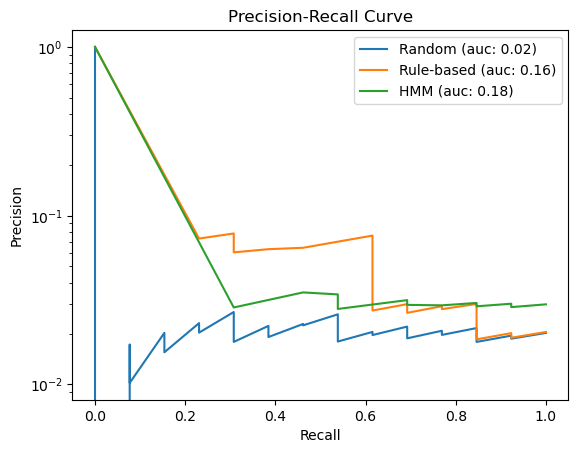

In [22]:
PRCombine(ps=[p_rand, p_rb, p_hmm], rs=[r_rand, r_rb, r_hmm], aucs=[pr_auc_rand, pr_auc_rb, pr_auc_hmm],
          labels=['Random', 'Rule-based', 'HMM'])

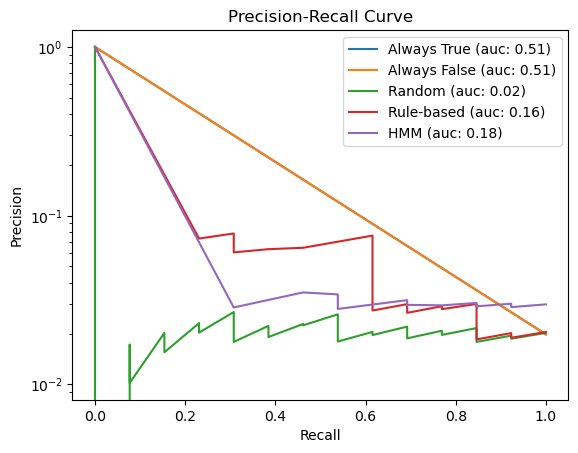

In [23]:
PRCombine(ps=[p_true, p_false, p_rand, p_rb, p_hmm], rs=[r_true, r_false, r_rand, r_rb, r_hmm],
          aucs=[pr_auc_true, pr_auc_false, pr_auc_rand, pr_auc_rb, pr_auc_hmm], 
          labels=['Always True', 'Always False', 'Random', 'Rule-based', 'HMM'])

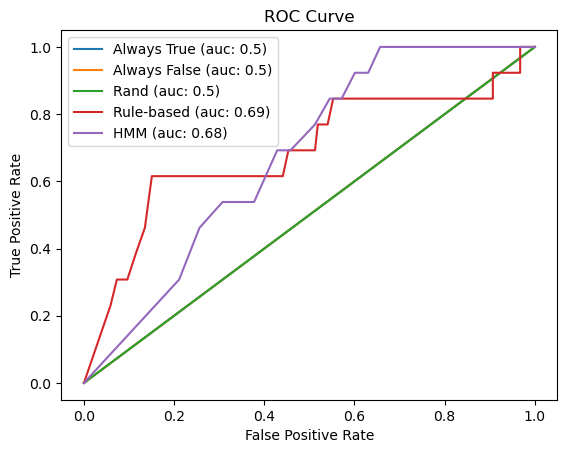

In [24]:
ROCCombine([fpr_true, fpr_false, fpr_rand, fpr_rb, fpr_hmm], 
           [tpr_true, tpr_false, tpr_rand, tpr_rb, tpr_hmm], 
           [auroc_true, auroc_false, auroc_rand, auroc_rb, auroc_hmm], 
           ['Always True', 'Always False', 'Rand', 'Rule-based', 'HMM'])

In [29]:
def evaluate_predictions(G2_pred, targets):
    num_edges = len([edge for edge in G2_pred.edges])
    
    edge_weights = nx.get_edge_attributes(G2_pred, 'weight')
    
    # Get number of roads with no matches
    nomatch_edges = [edge for edge, weight in edge_weights.items() if weight == 0]
    num_nomatch_roads = len(nomatch_edges)
    
    # Get number of roads that are actually removed
    removed_edges = [edge for edge, weight in targets.items() if weight == 1]
    num_removed_roads = len(removed_edges)
    
    print(f'# of roads with no matches: {num_nomatch_roads}/{num_edges} ({round((num_nomatch_roads/num_edges)*100,2)}%)')
    print(f'# of roads actually removed: {num_removed_roads}/{num_edges} ({round((num_removed_roads/num_edges)*100,2)}%)')
    
    # Get number of removed roads that were matched with trajectories
    removed_edges_weights = [edge_weights[edge] for edge in removed_edges]
    num_removed_edges_w_weights = len([weight for weight in removed_edges_weights if weight != 0])
    print(f'# of removed roads with non-zero weight: {num_removed_edges_w_weights}/{num_edges} ({round((num_removed_edges_w_weights/num_edges)*100,2)}%)')
    
    # Get average weight of removed roads
    avg_removed_road_weight = np.mean(removed_edges_weights)
    print(f'Average edge weight of removed segments: {avg_removed_road_weight}')
    
    # Get average weight of non removed roads
    nonremoved_edges_weights = [weight for edge, weight in edge_weights.items() if edge not in removed_edges]
    avg_nonremoved_road_weight = np.mean(nonremoved_edges_weights)
    print(f'Average edge weight of remaining segments: {avg_nonremoved_road_weight}')
    
    # Get number of non removed roads that weren't matched
    nonremoved_nomatch_edges = [weight for edge, weight in edge_weights.items() if edge not in removed_edges and weight == 0]
    num_nonremoved_nomatch_edges = len(nonremoved_nomatch_edges)
    print(f"# of non removed roads that weren't matched: {num_nonremoved_nomatch_edges}/{num_edges} ({round((num_nonremoved_nomatch_edges/num_edges)*100,2)}%)")
    
    
    
evaluate_predictions(G2_pred_hmm, groundtruth_labels(G1,G2))

# of roads with no matches: 140/657 (21.31%)
# of roads actually removed: 13/657 (1.98%)
# of removed roads with non-zero weight: 7/657 (1.07%)
Average edge weight of removed segments: -1.3846153846153846
Average edge weight of remaining segments: -20.922360248447205
# of non removed roads that weren't matched: 134/657 (20.4%)


In [33]:
evaluate_predictions(G2_pred_rb, groundtruth_labels(G1,G2))

# of roads with no matches: 41/657 (6.24%)
# of roads actually removed: 13/657 (1.98%)
# of removed roads with non-zero weight: 10/657 (1.52%)
Average edge weight of removed segments: -28.76923076923077
Average edge weight of remaining segments: -81.8944099378882
# of non removed roads that weren't matched: 38/657 (5.78%)


In [34]:
import os
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from IPython.display import Image

def save_maps(G1, G2, T2, G2_pred, figsize=(10,10)):
    if not os.path.exists('./images'):
        os.mkdir('./images')
    
    G1_d, G12_d, G2_d, G21_d = compare_snapshots(G1,G2)
    plot_graph(G12_d, show_img=False, figsize=figsize)
    plt.savefig('./images/G2_changes.png')
    
    plot_graph(G2_pred, show_img=False, use_weights=True, figsize=(figsize[0]+2, figsize[1]))
    plt.savefig('./images/G2_pred.png')
    
    plot_graph(snapshot_to_nxgraph(G1,T2['T']), show_img=False, figsize=figsize)
    plt.savefig('./images/G1T2.png')
    

save_maps(G1, G2, T2, G2_pred_rb)

In [36]:
@interact
def compare_maps(file=os.listdir('./images/')):
    display(Image('./images/'+file))


interactive(children=(Dropdown(description='file', options=('G2_changes.png', 'G1T2.png', 'PR_curve_1.png', 'G…